In [68]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
from joblib import Parallel, delayed

In [69]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"
output_dir = project_dir + '/Output'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Downstream_Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
extended_non_cds_regions_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_Non_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis'
num_cores = 16

In [70]:
with open(cryptic_output_path + '/' + 'variant_count_dictionary.pkl', 'rb') as f:
    variant_count_dict = pickle.load(f)    

In [71]:
genome_record = next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank"))
full_sequence = genome_record.seq
actual_cds_boundaries = []
for feature in genome_record.features:

        if feature.type == 'CDS':
            a = feature.qualifiers  
            actual_cds_boundaries.append((a.get("locus_tag")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   

In [72]:
print(min([x[2]-x[1] for x in actual_cds_boundaries]))

90


In [133]:
def bin_formula(max_bin_counts, tot_bin_counts, in_frame = False):
    #successes = 0
    #if in_frame == False:
    #    for i in range(10000):
    #        a = np.random.default_rng().multinomial(tot_bin_counts, np.array([1/3, 1/3, 1/3]), size=None)
    #        if max(a) >= max_bin_counts:
    #            successes +=1
    #else:
    #    for i in range(10000):
    #        a = np.random.default_rng().multinomial(tot_bin_counts, np.array([1/3, 1/3, 1/3]), size=None)
    #        if a[0] >= max_bin_counts:
    #            successes +=1
    #return successes / 10000
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

In [135]:
def mutation_bin_probability(start, end, strand):
    mutations = []
    for i in range(start,end):
        for letter in ['a','c','g','t']:
            if (i+1, 'SNP', letter) in variant_count_dict:        #Variant count dictionary positions are one indexed
                mutations.append(i)
    bin_counts =[0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (1, sum(bin_counts), bin_counts)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)), sum(bin_counts), bin_counts)  

In [156]:
def max_orf(seq_start, seq_stop):
    max_len = 0
    orf_length = 0
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (full_sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(full_sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for i in range(seq_len - 2):
            test_codon = temp[i: i+3] 
            if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
                for j in range(i + 3, seq_len - 2, 3):
                    test_codon_2 = temp[j: j+3] 
                    if test_codon_2 in ['TAG','TGA','TAA']:
                        orf_length = j - i
                        break
                if orf_length > max_len and ((frame == 'Forward' and mutation_bin_probability(seq_start+i, seq_start+j+3, 1)[0]<0.1)
                                             or (frame == 'Reverse' and mutation_bin_probability(seq_start+seq_len-(j+3), seq_start+seq_len-i, -1)[0]<0.1)):
                    max_len = orf_length
                    if frame == 'Forward':
                        strand = 1
                        start_pos = i
                        end_pos = j+3
                        
                    else:
                        strand = -1
                        start_pos = seq_len-(j+3)
                        end_pos = seq_len-i
                       
      
    if start_pos == -999:
        return(0,0,0)
    else:
        return(seq_start+start_pos, seq_start+end_pos, strand)   #, mutation_bin_probability(seq_start+start_pos, seq_start+end_pos, strand, in_frame=True))

In [157]:
max_orf(0,15000)

(7301, 9818, 1)

In [170]:
mutation_bin_probability(748598,749504,-1)

(0.0, 544, [132, 132, 280])

In [159]:
num_iterations = 0
cds_boundaries = [[0, 0], [4411530, 4411530]]
cds_dict = {}
for i in cds_boundaries:
    cds_dict[tuple(i)] = 1
exhausted_cds = []
while len(exhausted_cds) < len(cds_boundaries) - 1:
    temp_boundaries = []
    for i, (x,y) in enumerate((cds_boundaries)):
        if i < len(cds_boundaries) - 1:
            if [x,y] in exhausted_cds:
                pass
            else:
                temp = cds_boundaries[i+1][0]
                res = max_orf(y, temp)
                if (res[1] - res[0] < 100):
                    exhausted_cds.append([x,y])
                else:
                    temp_boundaries.append([res[0], res[1]])
                    cds_dict[(res[0],res[1])] = res[2]
                
    cds_boundaries = sorted(cds_boundaries + temp_boundaries, key=lambda x: x[0])
    print("iteration " + str(num_iterations) + ":  "+str(len(cds_boundaries))+ " found.  "+str(len(exhausted_cds))+" exhausted regions")
    num_iterations += 1

iteration 0:  3 found.  0 exhausted regions
iteration 1:  5 found.  0 exhausted regions
iteration 2:  9 found.  0 exhausted regions
iteration 3:  17 found.  0 exhausted regions
iteration 4:  31 found.  2 exhausted regions
iteration 5:  58 found.  3 exhausted regions
iteration 6:  105 found.  10 exhausted regions
iteration 7:  185 found.  24 exhausted regions
iteration 8:  315 found.  54 exhausted regions
iteration 9:  500 found.  129 exhausted regions
iteration 10:  749 found.  250 exhausted regions
iteration 11:  1034 found.  463 exhausted regions
iteration 12:  1377 found.  690 exhausted regions
iteration 13:  1733 found.  1020 exhausted regions
iteration 14:  2110 found.  1355 exhausted regions
iteration 15:  2504 found.  1715 exhausted regions
iteration 16:  2908 found.  2099 exhausted regions
iteration 17:  3255 found.  2560 exhausted regions
iteration 18:  3541 found.  2968 exhausted regions
iteration 19:  3773 found.  3308 exhausted regions
iteration 20:  3931 found.  3614 exhau

In [161]:
t_lengths = [x[1]-x[0] for x in cds_boundaries]
a_lengths = [x[2]-x[1] for x in actual_cds_boundaries]

<AxesSubplot:ylabel='Count'>

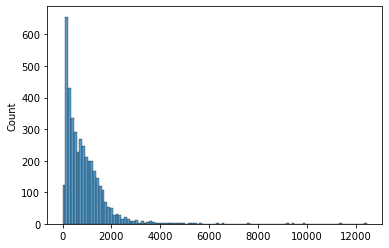

In [162]:
sns.histplot(t_lengths)

<AxesSubplot:ylabel='Count'>

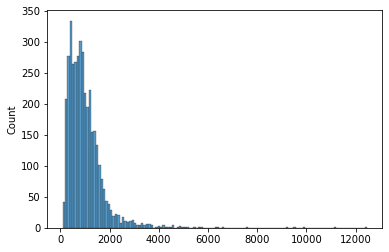

In [163]:
sns.histplot(a_lengths)

In [164]:
def max_overlap(boundary, comparison_boundaries):
    max_overlap = 0
    comparison_boundary_0 = 0
    comparison_boundary_1 = 0
    locus = ''
    strand = 1
    for bound in comparison_boundaries:
        overlap = min(boundary[1], bound[2]) - max(boundary[0], bound[1])
        if overlap > max_overlap:
            max_overlap = overlap
            comparison_boundary_0 = bound[1]
            comparison_boundary_1 = bound[2]
            locus = bound[0]
            strand = bound[3]
    return(locus, strand, comparison_boundary_0, comparison_boundary_1, max_overlap)

In [165]:
temp = []
for bound in tqdm(cds_boundaries):
    a = max_overlap(bound, actual_cds_boundaries)
    if a[3] > 0:
        temp.append([a[0],a[1],a[2],a[3],a[4], cds_dict[(bound[0],bound[1])], bound[0], bound[1], bound[0]-a[2], bound[1]-a[3]])
df = pd.DataFrame(temp, columns = ['locus','annotation_strand','annotation_start','annotation_end', 'overlap', 'simulated_strand','simulated_start', 'simulated_end', 'start_offset','end_offset'])

100%|██████████| 4138/4138 [00:03<00:00, 1186.22it/s]


In [166]:
matched_genes = df.query('start_offset == 0 and end_offset == 0')
print(len(matched_genes))

1306


In [167]:
longer_simulated = df.query('start_offset < 0 and end_offset > 0')
print(len(longer_simulated))
print(longer_simulated)
longer_simulated.to_csv(cryptic_output_path + '/longer_orfs.csv')

32
        locus  annotation_strand  annotation_start  annotation_end  overlap  \
404    Rv0397                  1            475815          476184      369   
556   Rv0543c                 -1            635572          635875      303   
606   Rv0596c                 -1            695227          695485      258   
620   Rv0616A                  1            710781          711009      228   
635   Rv0634A                  1            731112          731364      252   
654    Rv0652                  1            748848          749241      393   
746   Rv0756c                 -1            850740          851466      726   
801   Rv0814c                 -1            908180          908483      303   
1174   Rv1195                  1           1339002         1339302      300   
1258   Rv1275                  1           1424750         1425293      543   
1402  Rv1397c                 -1           1574111         1574513      402   
1549   Rv1539                  1           174224

In [34]:
for i in cds_boundaries:
    if i[1] - i[0] > 6000:
        print(i)

[109976, 117539]
[366149, 373334]
[424776, 434679]
[1722082, 1728409]
[1875303, 1881684]
[2294530, 2306986]
[2840122, 2849332]
[3255684, 3262251]
[3276379, 3282715]
[3729363, 3736935]
[3743710, 3753184]
[3755951, 3767315]
[4293224, 4299605]


In [16]:
print(full_sequence[3753764:3754256])

GTGACTGCCGAGAATCCAGGACGGAGCAGGCGGACGCTGGTCGGAATCGACGCGGCGATCACGGCCTGTCACCACATCGCGATCCGCGATGATGTCGGTGCGAGGTCGATTCGATTCAGTGTCGAACCCACGCTGGCCGGACTGCGCACCCTCACCGACAAGCTCAGCGGTTACGACGATATCGACGCCACCGTGGAACCGACCTCGATGACGTGGCTGCCGCTCACGATCGCTGTCGAGAATGCCGGTGACACCATGCACATGGCCGGCGCGCGGCATTGCGCCCGGCTGCGGGGTGCGATCGTGGGCAAGAGCAAGTCCGACGTCATCGACGCCGAGGTTCTCACCCGCGCCAGCGAGGTGTTCGACCTGACGCCGCTGACACTGCCGACGCCCGCGCAGTTGGCGTTACGTCGATCGGTGATCCGACGTGCCGGCGCAGTGATTGACGCGAACCGGTCCTGGCGTCGGTTGATGTCGTTGGCGCGGTAG


In [128]:
print(mutation_bin_probability(455636,455858, 1, in_frame=True))
print(mutation_bin_probability(455558,456137, -1, in_frame=True))

(0.4257688693959465, 101, [32, 34, 35])
(0.2710740880922925, 249, [73, 88, 88])


In [113]:
print(binom.cdf(20,10,1/3))

1.0


In [99]:
print(longer_simulated.iloc[0]['locus'])

Rv0011c


In [175]:
for i in actual_cds_boundaries:
    if mutation_bin_probability(i[1],i[2],i[3])[0] > 0.4:
        
        temp = df[df['locus'] == i[0]]
        if len(temp)== 1:
            if mutation_bin_probability(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand'])[0]<0.1:
                print(temp.iloc[0]['locus'])
                print ([i[1],i[2],i[3]],mutation_bin_probability(i[1],i[2],i[3]))
                print ("alternative")
                print([temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']], mutation_bin_probability(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']))

Rv0115a
[139955, 140144, 1] (0.9653475598668086, 102, [35, 41, 26])
alternative
[139995, 140223, -1] (0.08763264818373506, 113, [40, 28, 45])
Rv0195
[230898, 231534, 1] (0.7816989513191005, 312, [116, 98, 98])
alternative
[230956, 231169, 1] (0.04337149036841148, 100, [30, 28, 42])
Rv0246
[296808, 298119, 1] (0.6286172827138701, 598, [194, 208, 196])
alternative
[296966, 297728, 1] (0.027593222963494868, 355, [114, 105, 136])
Rv0279c
[336559, 339073, -1] (0.40740740740740744, 4, [1, 1, 2])
alternative
[336472, 336898, 1] (0.06729479840012731, 34, [8, 10, 16])
Rv0330c
[395346, 396087, -1] (0.442352612144154, 319, [117, 94, 108])
alternative
[395564, 396050, -1] (0.0927946175954224, 214, [62, 71, 81])
Rv0345
[415049, 415460, 1] (0.5284844543087819, 174, [54, 62, 58])
alternative
[415347, 415500, 1] (0.009767128438674222, 57, [16, 13, 28])
Rv0349
[418948, 419608, 1] (0.43534565981670426, 253, [90, 77, 86])
alternative
[419279, 419417, 1] (0.09256158255111746, 59, [14, 20, 25])
Rv0371c
[44

In [108]:
print(actual_cds_boundaries[1][0])

Rv0002
